# DEPENDENCIES

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import (
    adfuller,
    arma_order_select_ic,
    grangercausalitytests,
)
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.vector_ar.vecm import (
    coint_johansen,
    select_order,
    select_coint_rank,
)
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.vector_ar.vecm import VECM

In [4]:
def plot_acf(df, col):
    fig, axes = plt.subplots(2, 2, figsize=(24, 12))
    ax1, ax2, ax3, ax4 = axes.flatten()

    sm.graphics.tsa.plot_acf(df[col].values.squeeze(), lags=20, ax=ax1)
    ax1.set_title(f"{col}: ACF of Original Data")

    sm.graphics.tsa.plot_acf(df[col].diff().dropna().values.squeeze(), lags=20, ax=ax2)
    ax2.set_title(f"{col}: ACF of Differenced Data")

    sm.graphics.tsa.plot_pacf(df[col].values.squeeze(), lags=20, ax=ax3)
    ax3.set_title(f"{col}: PACF of Original Data")
    sm.graphics.tsa.plot_pacf(df[col].diff().dropna().values.squeeze(), lags=20, ax=ax4)
    ax4.set_title(f"{col}: PACF of Differenced Data")

    plt.tight_layout()

    plt.show()

# READ DATA

In [85]:
days = [0, -1, -2]
df = []
for day in days:
    data = pd.read_csv(
        f"C:/Users/edmun/OneDrive/Desktop/2025-IMC-Global-Trading-Challenge/Backtest/resources/round1/prices_round_1_day_{day}.csv",
        sep=";",
    )
    data["timestamp"] = data["timestamp"] + 1_000_000 * abs(data["day"])
    df.append(data)

data = pd.concat(df)

In [86]:
#################################### VOLUME METRICS ####################################

# Most Bid Volume - Identifies which bid price has the highest volume.
data["most_bid_volume_idx"] = data[
    ["bid_volume_1", "bid_volume_2", "bid_volume_3"]
].idxmax(axis=1)

# Most Ask Volume - Identifies which ask price has the highest volume.
data["most_ask_volume_idx"] = data[
    ["ask_volume_1", "ask_volume_2", "ask_volume_3"]
].idxmax(axis=1)

# Highest Bid Volume - The highest bid volume across the three bid price levels.
data["most_bid_volume"] = data[["bid_volume_1", "bid_volume_2", "bid_volume_3"]].max(
    axis=1
)

# Highest Ask Volume - The highest ask volume across the three ask price levels.
data["most_ask_volume"] = data[["ask_volume_1", "ask_volume_2", "ask_volume_3"]].max(
    axis=1
)

data["total_bid_volume"] = data[["bid_volume_1", "bid_volume_2", "bid_volume_3"]].sum(
    axis=1
)

data["total_ask_volume"] = data[["ask_volume_1", "ask_volume_2", "ask_volume_3"]].sum(
    axis=1
)

data["volume_ratio"] = data["total_bid_volume"] / data["total_ask_volume"]

data["orderbook_imb"] = (
    (data["total_bid_volume"] - data["total_ask_volume"])
    / (data["total_bid_volume"] + data["total_ask_volume"])
    * 100
)

data["price_impact_sell"] = data["total_bid_volume"] / (
    data["ask_price_1"] - data["bid_price_1"]
)

data["price_impact_buy"] = data["total_ask_volume"] / (
    data["ask_price_1"] - data["bid_price_1"]
)

data["rate_of_bid"] = data.groupby("product")["total_bid_volume"].diff()

data["rate_of_ask"] = data.groupby("product")["total_ask_volume"].diff()


#################################### PRICE METRICS ####################################
# Most Bid Price - Determines the bid price corresponding to the highest bid volume.
data["most_bid"] = np.where(
    data["most_bid_volume_idx"] == "bid_volume_1",
    data["bid_price_1"],
    np.where(
        data["most_bid_volume_idx"] == "bid_volume_2",
        data["bid_price_2"],
        np.where(
            data["most_bid_volume_idx"] == "bid_volume_3", data["bid_price_3"], np.nan
        ),
    ),
)

# Most Ask Price - Determines the ask price corresponding to the highest ask volume.
data["most_ask"] = np.where(
    data["most_ask_volume_idx"] == "ask_volume_1",
    data["ask_price_1"],
    np.where(
        data["most_ask_volume_idx"] == "ask_volume_2",
        data["ask_price_2"],
        np.where(
            data["most_ask_volume_idx"] == "ask_volume_3", data["ask_price_3"], np.nan
        ),
    ),
)

#################################### MID PRICE METRICS ####################################
# Most Mid Price - The mid price of the highest bid and ask prices.
data["most_mid"] = (data["most_ask"] + data["most_bid"]) / 2


#################################### VWAP METRICS ####################################
# Most Micro Price - A weighted average price using both bid and ask volumes.
data["most_micro"] = (
    data["most_ask"] * data["most_bid_volume"]
    + data["most_bid"] * data["most_ask_volume"]
) / (data["most_ask_volume"] + data["most_bid_volume"])

# Micro Price - A weighted average price based on the first bid and ask levels.
data["micro_price"] = (
    data["ask_price_1"] * data["bid_volume_1"]
    + data["bid_price_1"] * data["ask_volume_1"]
) / (data["ask_volume_1"] + data["bid_volume_1"])

# Ask VWAP - The volume-weighted average price for the ask side using the top 3 ask levels.
data["ask_vwap"] = (
    data["ask_price_1"] * data["ask_volume_1"]
    + data["ask_price_2"] * data["ask_volume_2"]
    + data["ask_price_3"] * data["ask_volume_3"]
) / (data["ask_volume_1"] + data["ask_volume_2"] + data["ask_volume_3"])

# Bid VWAP - The volume-weighted average price for the bid side using the top 3 bid levels.
data["bid_vwap"] = (
    data["bid_price_1"] * data["bid_volume_1"]
    + data["bid_price_2"] * data["bid_volume_2"]
    + data["bid_price_3"] * data["bid_volume_3"]
) / (data["bid_volume_1"] + data["bid_volume_2"] + data["bid_volume_3"])

# VWAP Mid - The VWAP midpoint between the ask and bid sides.
data["vwap_mid"] = (data["ask_vwap"] + data["bid_vwap"]) / 2


In [87]:
data.columns

Index(['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss',
       'most_bid_volume_idx', 'most_ask_volume_idx', 'most_bid_volume',
       'most_ask_volume', 'total_bid_volume', 'total_ask_volume',
       'volume_ratio', 'orderbook_imb', 'price_impact_sell',
       'price_impact_buy', 'rate_of_bid', 'rate_of_ask', 'most_bid',
       'most_ask', 'most_mid', 'most_micro', 'micro_price', 'ask_vwap',
       'bid_vwap', 'vwap_mid'],
      dtype='object')

In [8]:
prices = [
    "mid_price",
    "most_mid",
    "most_micro",
    "micro_price",
    "vwap_mid",
]

# Resin

In [9]:
resin = data[data["product"] == "RAINFOREST_RESIN"].fillna(0)

In [10]:
resin["bid_price_1"].value_counts().sort_index()

bid_price_1
9995      7689
9996     14890
9998      4305
10000      664
10002     2452
Name: count, dtype: int64

In [11]:
resin["ask_price_1"].value_counts().sort_index()

ask_price_1
9998      2514
10000      626
10002     4298
10004    14874
10005     7688
Name: count, dtype: int64

max sell @ bid = 9999 because min ask is 9998, sell at bid buy at ask

max buy @ ask = 10_001 because max bid = 10_002, buy at ask sell at bid

## KELP

In [12]:
kelp = data[data["product"] == "KELP"].fillna(0)

In [13]:
kelp

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,rate_of_bid,rate_of_ask,most_bid,most_ask,most_mid,most_micro,micro_price,ask_vwap,bid_vwap,vwap_mid
1,0,0,KELP,2028,30,0.0,0.0,0.0,0.0,2032,...,0.0,0.0,2028.0,2032.0,2030.0,2030.000000,2030.000000,0.0,0.0,0.0
4,0,100,KELP,2030,4,2028.0,31.0,0.0,0.0,2032,...,5.0,1.0,2028.0,2032.0,2030.0,2030.000000,2030.228571,0.0,0.0,0.0
8,0,200,KELP,2029,1,2028.0,21.0,0.0,0.0,2032,...,-13.0,-9.0,2028.0,2032.0,2030.0,2029.953488,2029.130435,0.0,0.0,0.0
10,0,300,KELP,2029,25,0.0,0.0,0.0,0.0,2032,...,3.0,3.0,2029.0,2032.0,2030.5,2030.500000,2030.500000,0.0,0.0,0.0
13,0,400,KELP,2029,2,2028.0,23.0,0.0,0.0,2030,...,0.0,6.0,2028.0,2032.0,2030.0,2029.916667,2029.250000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29987,-2,2999500,KELP,2027,26,0.0,0.0,0.0,0.0,2030,...,1.0,2.0,2027.0,2030.0,2028.5,2028.500000,2028.500000,0.0,0.0,0.0
29989,-2,2999600,KELP,2027,30,0.0,0.0,0.0,0.0,2030,...,4.0,4.0,2027.0,2030.0,2028.5,2028.500000,2028.500000,0.0,0.0,0.0
29991,-2,2999700,KELP,2026,22,0.0,0.0,0.0,0.0,2030,...,-8.0,-8.0,2026.0,2030.0,2028.0,2028.000000,2028.000000,0.0,0.0,0.0
29996,-2,2999800,KELP,2026,26,0.0,0.0,0.0,0.0,2028,...,4.0,7.0,2026.0,2030.0,2028.0,2028.000000,2027.793103,0.0,0.0,0.0


### ACF / PACF PLOT
Slow decay in ACF => time series not stationary => Differencing required

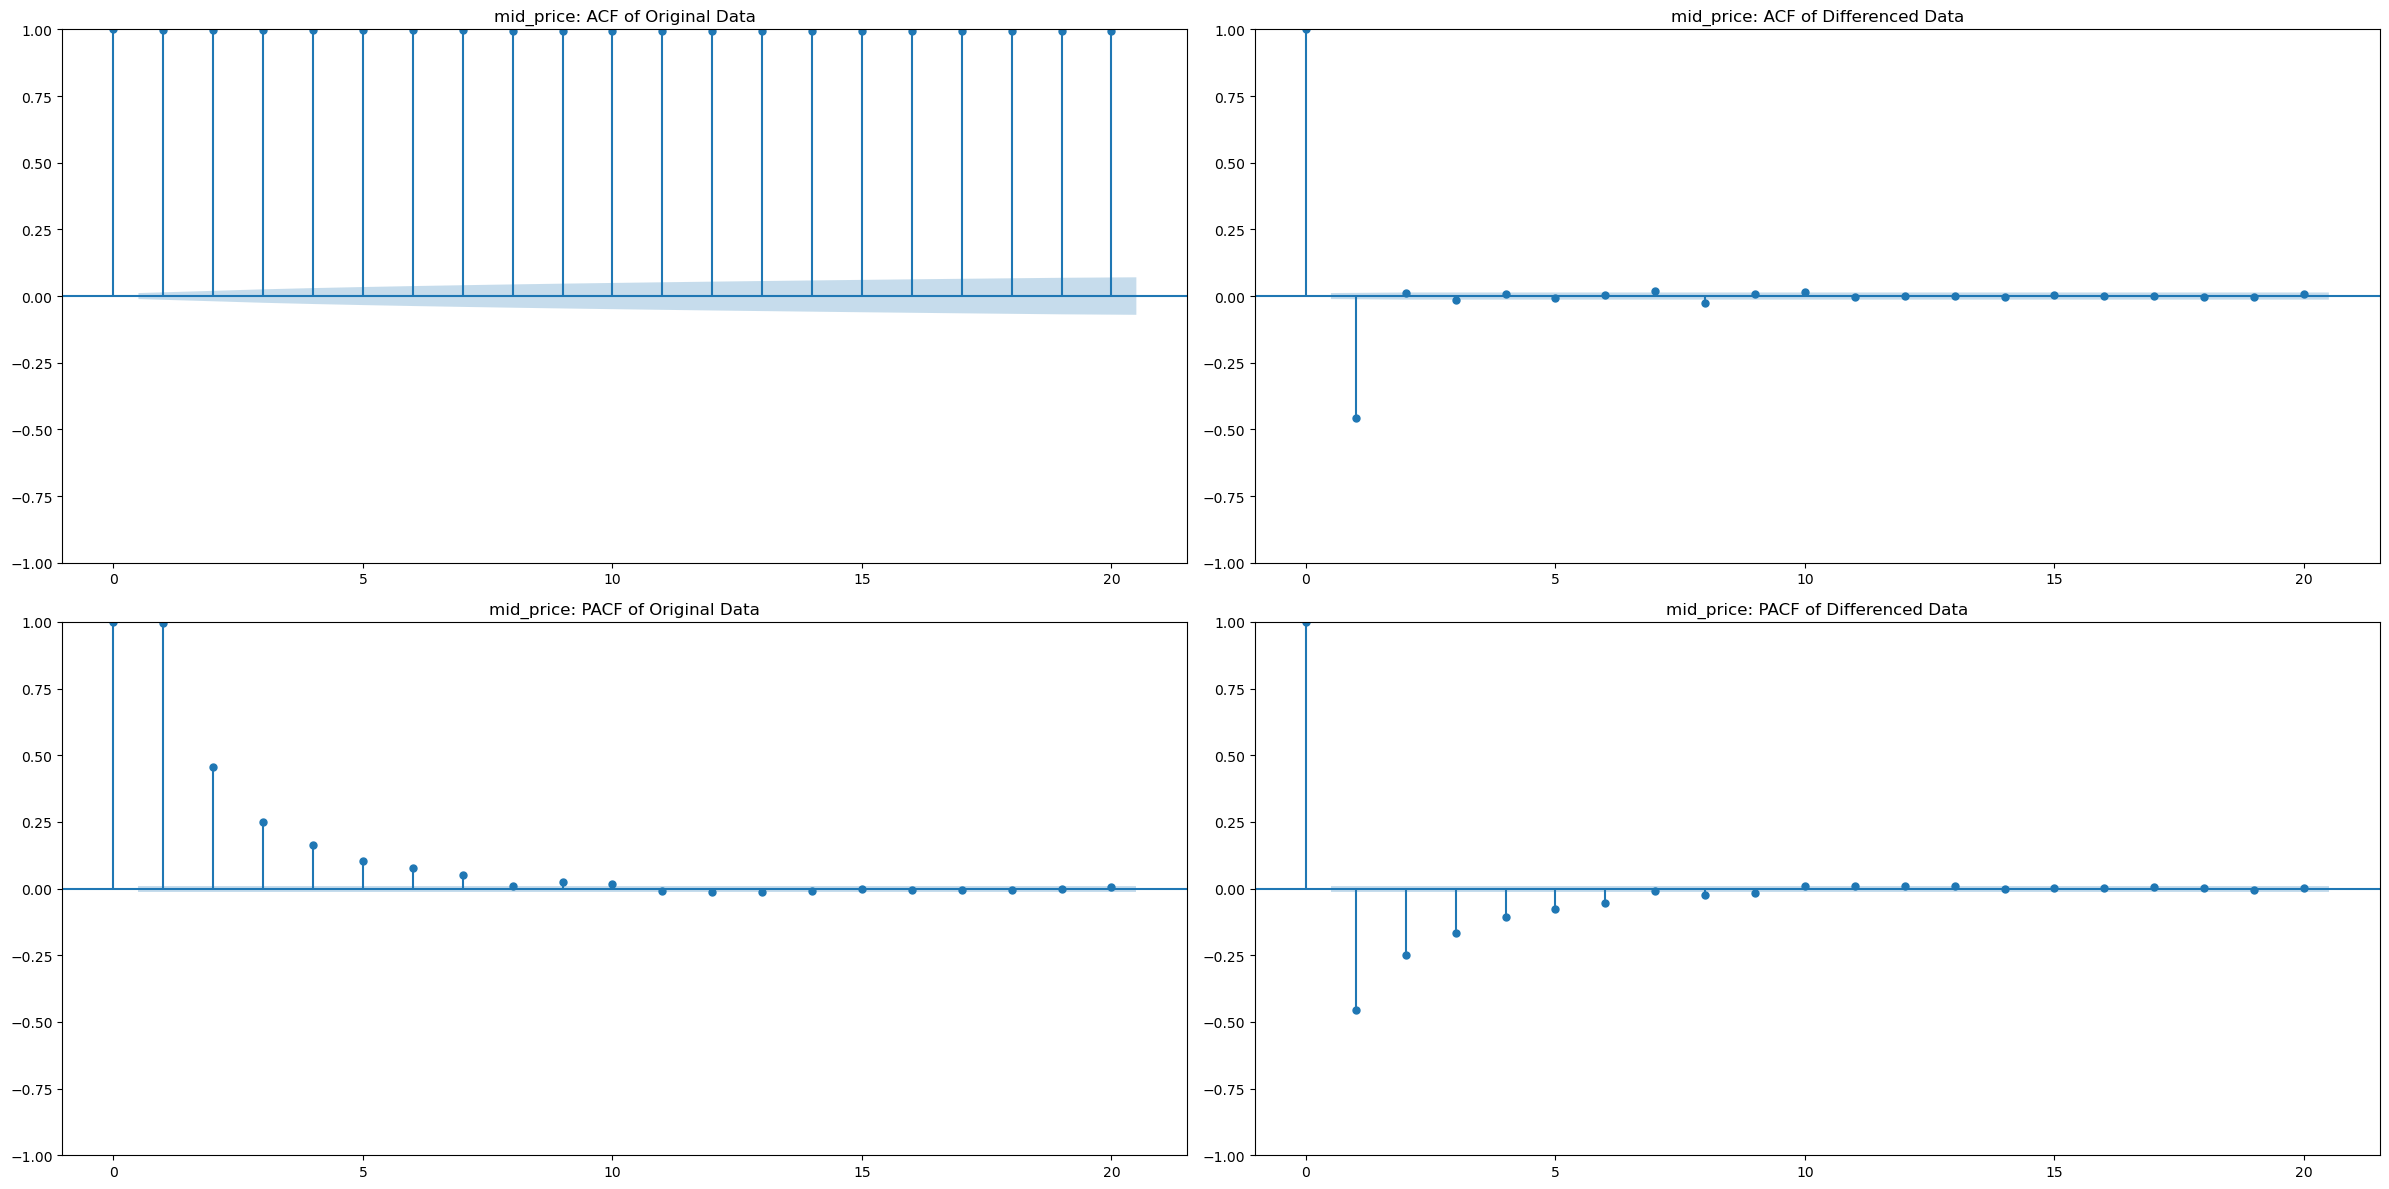

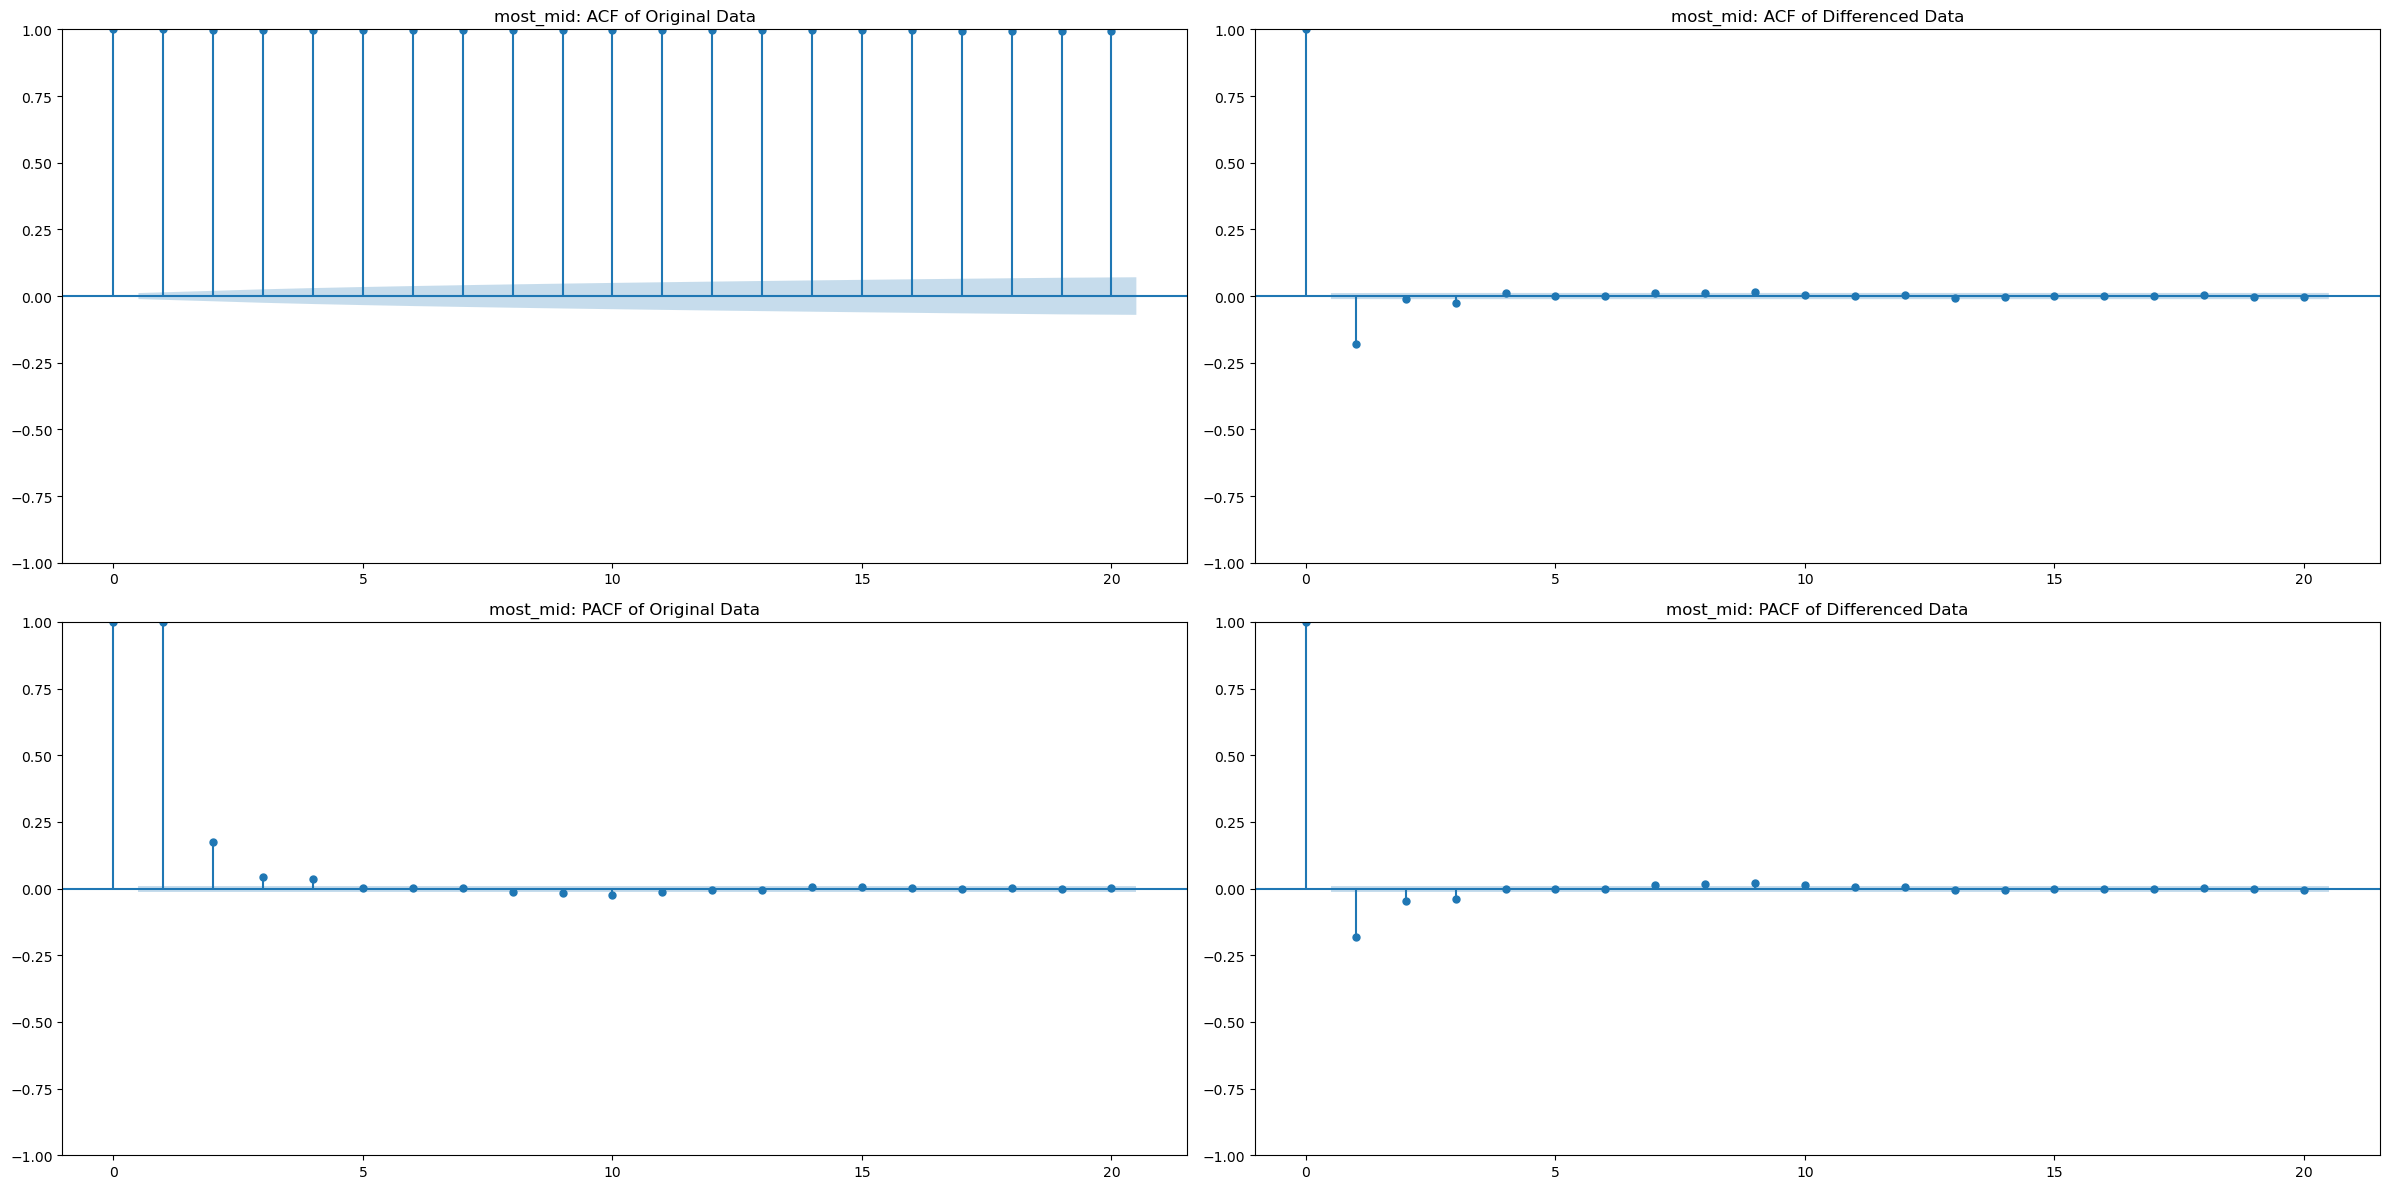

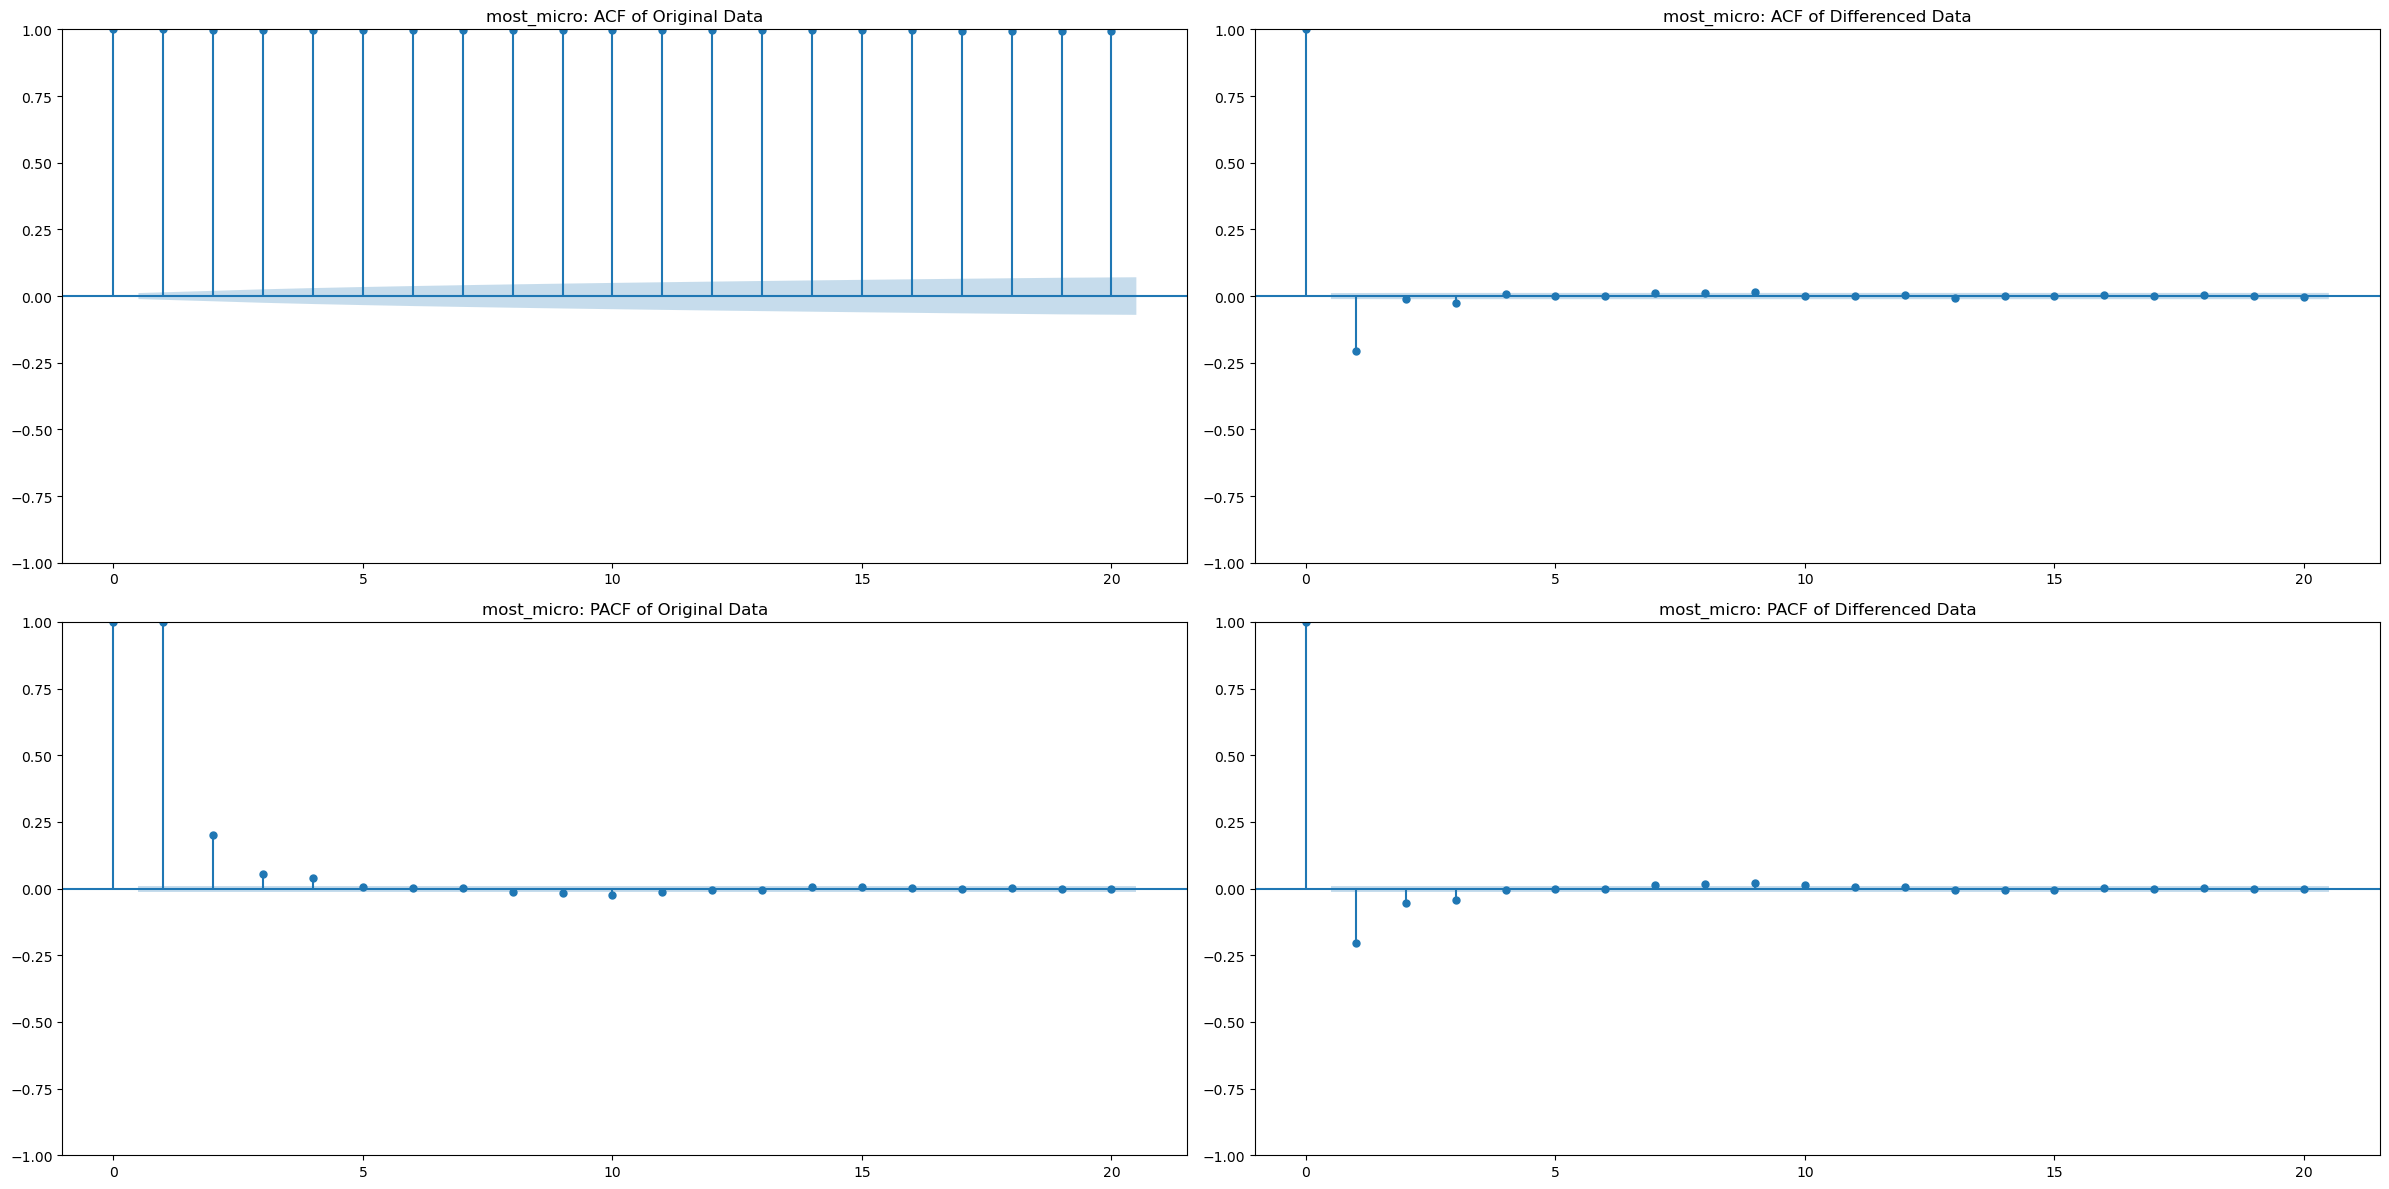

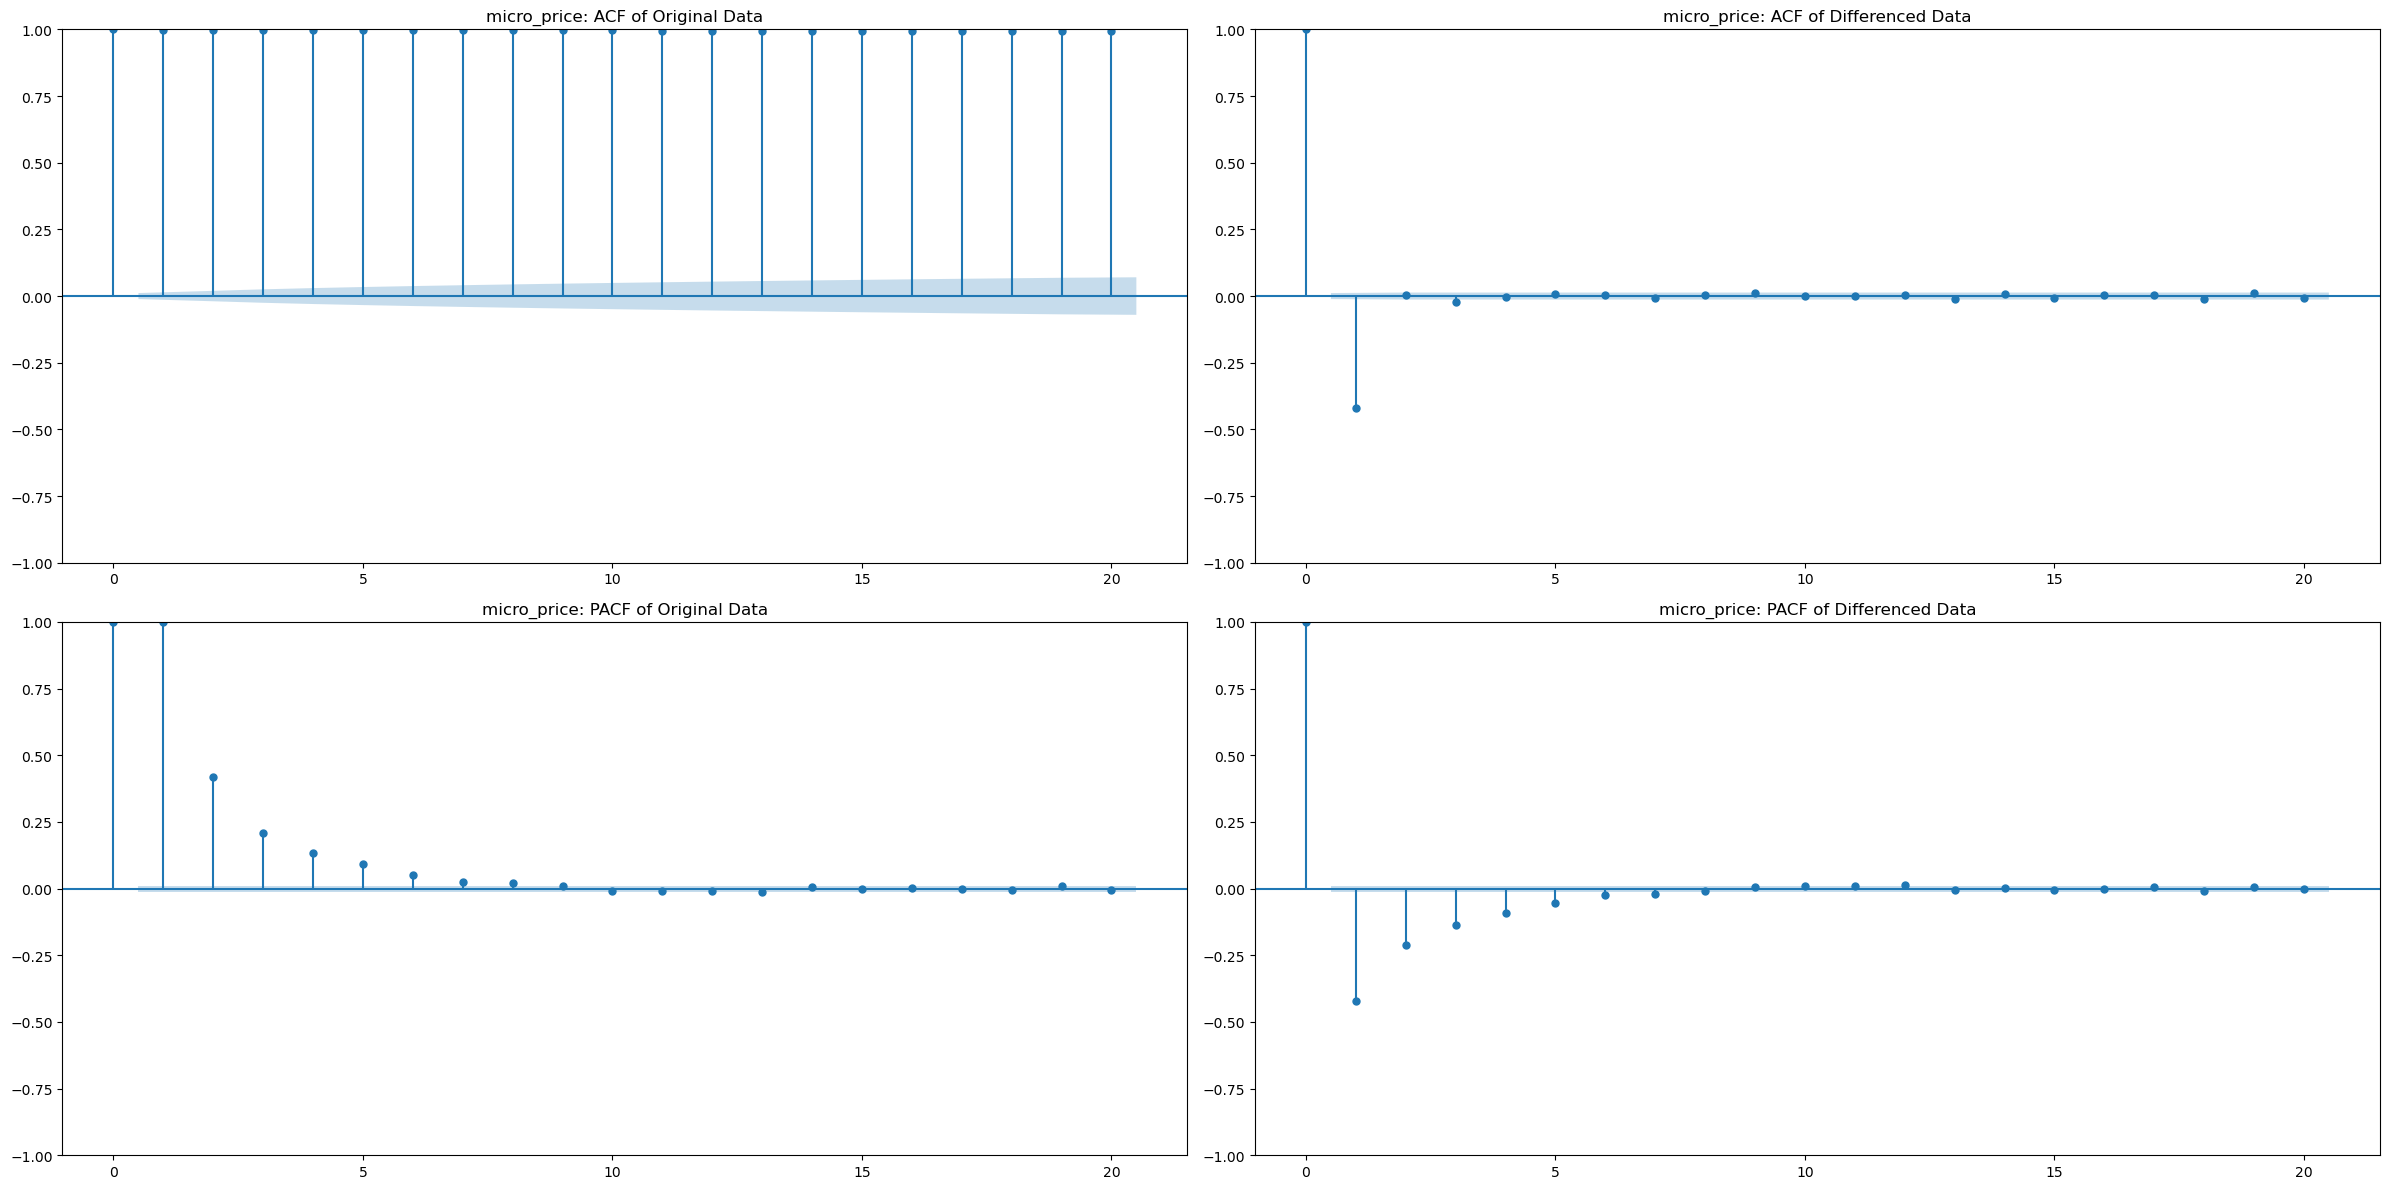

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1491: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1491: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)


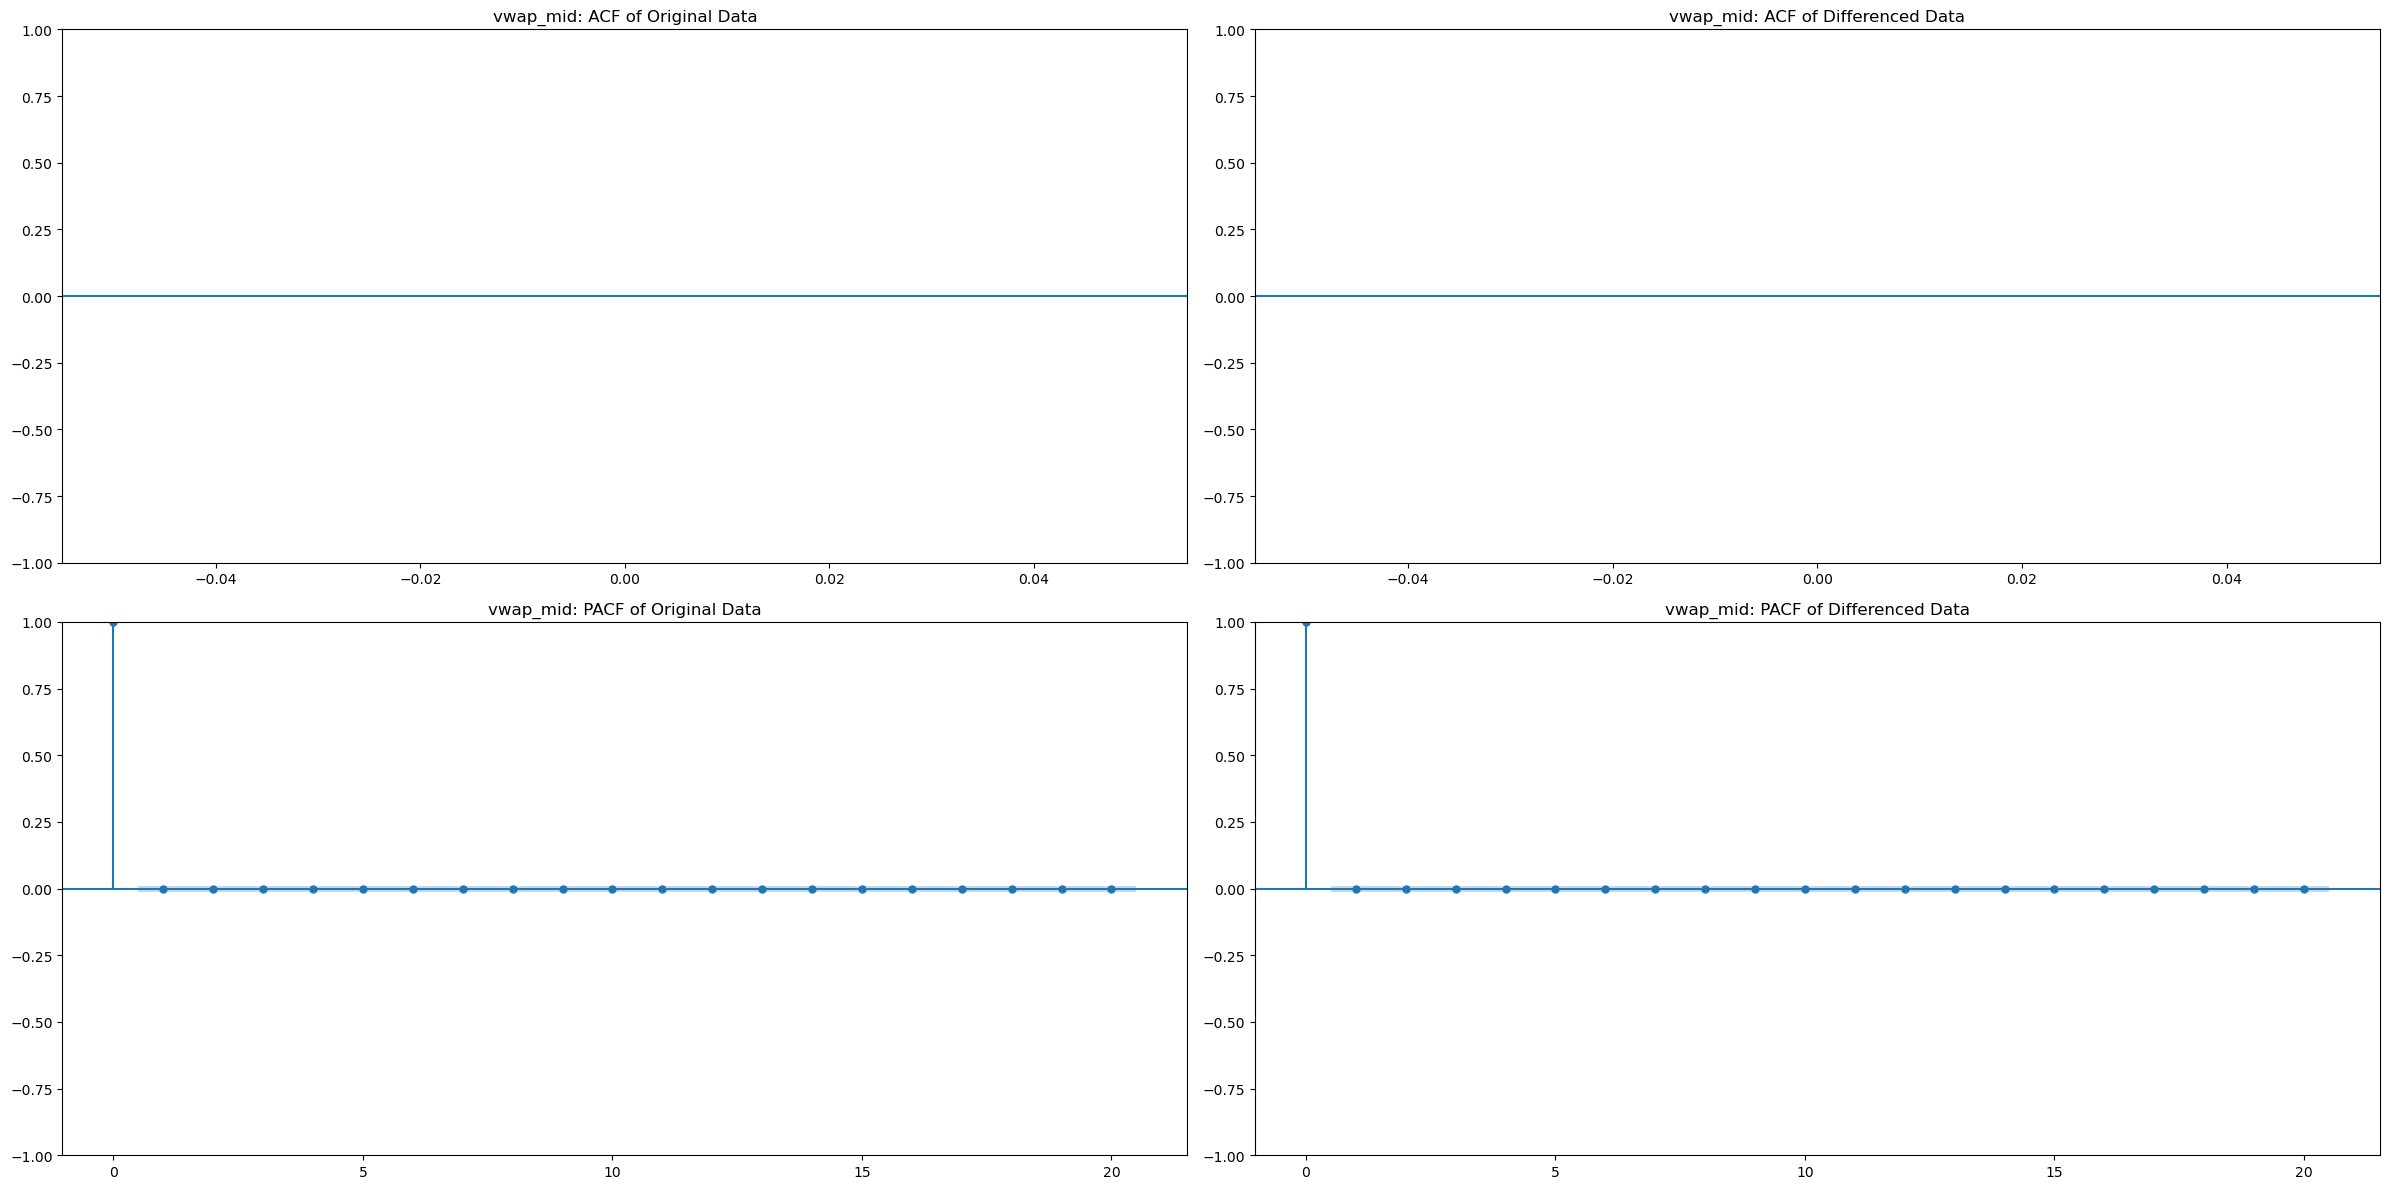

In [14]:
for price in prices:
    plot_acf(df=kelp, col=price)

After differencing, observe a 1 lag before sharp drop => differenced time series follows MA(1) \
This is confirmed by the exponentional decay in PACF of differenced time series

## MA(1) MODEL

## Single Factor
Running MA(1) model on 1 Endogeneous variable

In [15]:
for price in prices:
    print(f"########################   {price}   ##########################")
    arima = ARIMA(endog=kelp[price].values, order=(0, 1, 1)).fit()
    print(arima.summary())

########################   mid_price   ##########################
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                30000
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -30668.587
Date:                Wed, 09 Apr 2025   AIC                          61341.174
Time:                        22:44:05   BIC                          61357.792
Sample:                             0   HQIC                         61346.506
                              - 30000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6450      0.001  -1036.823      0.000      -0.646      -0.644
sigma2         0.4524      0.000    977.006      0.000       0.45

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1420: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                30000
Model:                 ARIMA(0, 1, 1)   Log Likelihood              344287.813
Date:                Wed, 09 Apr 2025   AIC                        -688571.626
Time:                        22:44:14   BIC                        -688555.008
Sample:                             0   HQIC                       -688566.294
                              - 30000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1      -3.348e-10   2.11e-20  -1.59e+10      0.000   -3.35e-10   -3.35e-10
sigma2       1.71e-11    1.1e-11      1.550      0.121   -4.53e-12    3.87e-11
Ljung-Box (L1) (Q):                    nan   Jarque-

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


## Single factor with exogeneous variable
Running MA(1) model on 1 Endogeneous variable + 1 Exogeneous variable

In [16]:
for price in prices[1:]:
    print(
        f"########################   MID_PRICE + {price}   ##########################"
    )
    arima = ARIMA(
        endog=kelp["mid_price"].values,
        exog=kelp[price].diff().fillna(0).values,
        order=(0, 1, 1),
    ).fit()
    print(arima.summary())

########################   MID_PRICE + most_mid   ##########################
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                30000
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -29964.255
Date:                Wed, 09 Apr 2025   AIC                          59934.509
Time:                        22:44:18   BIC                          59959.436
Sample:                             0   HQIC                         59942.507
                              - 30000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4103      0.001    463.299      0.000       0.409       0.412
ma.L1         -0.6354      0.001   -650.456      0.000

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3014: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse


## Single factor with multiple exogeneous variables
Running MA(1) model on 1 Endogeneous variable + multiple exogeneous variable

In [17]:
from itertools import combinations

for i in range(2, 5):
    for combi in combinations(prices[1:], i):
        print(
            f"########################   MID_PRICE + {combi}   ##########################"
        )
        arima = ARIMA(
            endog=kelp["mid_price"].values,
            exog=kelp[list(combi)].diff().fillna(0).values,
            order=(0, 1, 1),
        ).fit()
        print(arima.summary())

########################   MID_PRICE + ('most_mid', 'most_micro')   ##########################
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                30000
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -29958.576
Date:                Wed, 09 Apr 2025   AIC                          59925.152
Time:                        22:44:30   BIC                          59958.388
Sample:                             0   HQIC                         59935.816
                              - 30000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5511      0.044     12.442      0.000       0.464       0.638
x2            -0.1385      0.044    

## Potential Models

### MID PRICE + MICRO PRICE DIFF

In [18]:
arima = ARIMA(
    endog=kelp["mid_price"].values,
    exog=kelp["micro_price"].diff().fillna(0).values,
    order=(0, 1, 1),
).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                30000
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -28845.705
Date:                Wed, 09 Apr 2025   AIC                          57697.411
Time:                        22:44:56   BIC                          57722.338
Sample:                             0   HQIC                         57705.409
                              - 30000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2887      0.001    309.961      0.000       0.287       0.291
ma.L1         -0.6095      0.001   -542.971      0.000      -0.612      -0.607
sigma2         0.4006      0.001    407.181      0.0

In [19]:
arima.params

array([ 0.28871597, -0.60953949,  0.40059766])

### MID PRICE + NOST MID DIFF MICRO PRICE DIFF

In [20]:
arima = ARIMA(
    endog=kelp["mid_price"].values,
    exog=kelp[list(("most_mid", "most_micro"))].diff().fillna(0).values,
    order=(0, 1, 1),
).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                30000
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -29958.576
Date:                Wed, 09 Apr 2025   AIC                          59925.152
Time:                        22:44:59   BIC                          59958.388
Sample:                             0   HQIC                         59935.816
                              - 30000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5511      0.044     12.442      0.000       0.464       0.638
x2            -0.1385      0.044     -3.129      0.002      -0.225      -0.052
ma.L1         -0.6354      0.001   -651.235      0.0

In [21]:
arima.params

array([ 0.55108093, -0.13851862, -0.63535844,  0.43145155])

### MID PRICE + NOST MID DIFF + MOST MICRO DIFF + MICRO PRICE DIFF

In [22]:
arima = ARIMA(
    endog=kelp["mid_price"].values,
    exog=kelp[list(("most_mid", "most_micro", "micro_price"))].diff().fillna(0).values,
    order=(0, 1, 1),
).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                30000
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -28710.154
Date:                Wed, 09 Apr 2025   AIC                          57430.308
Time:                        22:45:02   BIC                          57471.853
Sample:                             0   HQIC                         57443.638
                              - 30000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6721      0.040     16.675      0.000       0.593       0.751
x2            -0.6095      0.041    -14.847      0.000      -0.690      -0.529
x3             0.2895      0.005     63.853      0.0

In [23]:
arima.params

array([ 0.67208221, -0.60954211,  0.28953753, -0.60728756,  0.39699316])

# SQUID INK

In [88]:
squid_ink = data[data["product"] == "SQUID_INK"]

In [89]:
squid_ink[squid_ink["day"] == 0]

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,rate_of_bid,rate_of_ask,most_bid,most_ask,most_mid,most_micro,micro_price,ask_vwap,bid_vwap,vwap_mid
2,0,0,SQUID_INK,1968,30,NaN,NaN,NaN,NaN,1971,...,NaN,NaN,1968.0,1971.0,1969.5,1969.500000,1969.500000,NaN,NaN,NaN
3,0,100,SQUID_INK,1969,4,1967.0,31.0,NaN,NaN,1971,...,5.0,1.0,1967.0,1971.0,1969.0,1969.000000,1969.228571,NaN,NaN,NaN
6,0,200,SQUID_INK,1966,1,1965.0,21.0,NaN,NaN,1969,...,-13.0,-9.0,1965.0,1969.0,1967.0,1966.953488,1966.130435,NaN,NaN,NaN
9,0,300,SQUID_INK,1965,25,NaN,NaN,NaN,NaN,1968,...,3.0,3.0,1965.0,1968.0,1966.5,1966.500000,1966.500000,NaN,NaN,NaN
14,0,400,SQUID_INK,1966,25,NaN,NaN,NaN,NaN,1968,...,0.0,6.0,1966.0,1969.0,1967.5,1967.500000,1967.612903,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29986,0,999500,SQUID_INK,1830,28,NaN,NaN,NaN,NaN,1833,...,2.0,2.0,1830.0,1833.0,1831.5,1831.500000,1831.500000,NaN,NaN,NaN
29989,0,999600,SQUID_INK,1832,7,1831.0,29.0,NaN,NaN,1834,...,8.0,1.0,1831.0,1835.0,1833.0,1833.071429,1833.555556,NaN,NaN,NaN
29993,0,999700,SQUID_INK,1834,1,1832.0,26.0,NaN,NaN,1835,...,-9.0,-3.0,1832.0,1835.0,1833.5,1833.500000,1834.037037,NaN,NaN,NaN
29994,0,999800,SQUID_INK,1837,27,NaN,NaN,NaN,NaN,1839,...,0.0,2.0,1837.0,1840.0,1838.5,1838.500000,1838.928571,NaN,NaN,NaN


In [91]:
sq = data[data["product"] == "SQUID_INK"].reset_index(drop=True)
kelp = data[data["product"] == "KELP"].reset_index(drop=True)

mid_coin = pd.merge(
    sq[["mid_price"]],
    kelp[["mid_price"]],
    how="left",
    left_index=True,
    right_index=True,
    suffixes=("_sq", "_kelp"),
)

In [92]:
vecm_order = select_order(mid_coin, maxlags=10)
vecm_order.summary()

,AIC,BIC,FPE,HQIC
0,0.9263,0.9280,2.525,0.9268
1,0.6821,0.6849,1.978,0.6830
2,0.6147,0.6186,1.849,0.6160
3,0.5851,0.5901,1.795,0.5867
4,0.5735,0.5796,1.774,0.5754
5,0.5671,0.5743,1.763,0.5694
6,0.5643,0.5726*,1.758,0.5669
7,0.5643,0.5737,1.758,0.5673
8,0.5638,0.5743,1.757,0.5671
9,0.5634,0.5750,1.757,0.5671


In [93]:
model = coint_johansen(endog=mid_coin, det_order=1, k_ar_diff=1)
print("Eigen statistic:")
print(model.eig)
print("Critical values:")
d = pd.DataFrame(model.cvt)
d.rename(columns={0: "90%", 1: "95%", 2: "99%"}, inplace=True)
print(d)
print()
print("Trace statistic:")
print(pd.DataFrame(model.lr1))


Eigen statistic:
[0.00103578 0.00035717]
Critical values:
       90%      95%      99%
0  16.1619  18.3985  23.1485
1   2.7055   3.8415   6.6349

Trace statistic:
           0
0  41.803645
1  10.716162


In [94]:
rank1 = select_coint_rank(
    mid_coin, det_order=1, k_ar_diff=1, method="trace", signif=0.01
)
print(rank1.summary())


Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          41.80          23.15
  1   2          10.72          6.635
-------------------------------------


In [95]:
# Perform Granger causality tests
max_lags = 5
gc_results = grangercausalitytests(mid_coin, max_lags, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.5402 , p=0.0000  , df_denom=29996, df_num=1
ssr based chi2 test:   chi2=19.5422 , p=0.0000  , df=1
likelihood ratio test: chi2=19.5358 , p=0.0000  , df=1
parameter F test:         F=19.5402 , p=0.0000  , df_denom=29996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=193.9386, p=0.0000  , df_denom=29993, df_num=2
ssr based chi2 test:   chi2=387.9419, p=0.0000  , df=2
likelihood ratio test: chi2=385.4548, p=0.0000  , df=2
parameter F test:         F=193.9386, p=0.0000  , df_denom=29993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=178.0224, p=0.0000  , df_denom=29990, df_num=3
ssr based chi2 test:   chi2=534.1920, p=0.0000  , df=3
likelihood ratio test: chi2=529.4912, p=0.0000  , df=3
parameter F test:         F=178.0224, p=0.0000  , df_denom=29990, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=149.2554

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [78]:
# Define a range of lag lengths to test
results = []
for d in ["n", "co", "ci", "lo", "Ii"]:
    vecm = VECM(
        mid_coin, k_ar_diff=1, coint_rank=1, deterministic=d
    )  # Adjust coint_rank as needed
    vecm_fit = vecm.fit()
    results.append((d, vecm_fit.llf))

    out = durbin_watson(vecm_fit.resid)
    for col, val in zip(mid_coin.columns, out):
        print((col), ":", round(val, 2))

    results_df = pd.DataFrame(results, columns=[d, "lIf"])
    print(results_df)


most_mid_sq : 2.0
most_mid_kelp : 2.04
   n         lIf
0  n -1570.44657
most_mid_sq : 2.0
most_mid_kelp : 2.03
   co          lIf
0   n -1570.446570
1  co -1569.037299
most_mid_sq : 2.0
most_mid_kelp : 2.03
   ci          lIf
0   n -1570.446570
1  co -1569.037299
2  ci -1569.037700
most_mid_sq : 2.0
most_mid_kelp : 2.04
   lo          lIf
0   n -1570.446570
1  co -1569.037299
2  ci -1569.037700
3  lo -1570.366701
most_mid_sq : 2.0
most_mid_kelp : 2.04
   Ii          lIf
0   n -1570.446570
1  co -1569.037299
2  ci -1569.037700
3  lo -1570.366701
4  Ii -1570.446570


In [96]:
vecm = VECM(
    mid_coin, k_ar_diff=1, coint_rank=1, deterministic="n"
)  # Including a linear trend
vecm_fit = vecm.fit()

print(vecm_fit.summary())


Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_sq
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.mid_price_sq      -0.1041      0.006    -17.786      0.000      -0.116      -0.093
L1.mid_price_kelp    -0.2909      0.015    -19.444      0.000      -0.320      -0.262
Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_kelp
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.mid_price_sq      -0.0146      0.002     -7.071      0.000      -0.019      -0.011
L1.mid_price_kelp    -0.4478      0.005    -84.828      0.000      -0.458      -0.437
            Loading coefficients (alpha) for equation mid_price_sq            
                 coef    std err          z    

In [97]:
out = durbin_watson(vecm_fit.resid)
for col, val in zip(mid_coin.columns, out):
    print(col, ":", round(val, 2))

mid_price_sq : 2.02
mid_price_kelp : 2.23


In [98]:
(
    vecm_fit.lin_trend_coint
    + vecm_fit.alpha @ (vecm_fit.beta.T @ mid_coin.iloc[-1].values)
    + vecm_fit.gamma @ (mid_coin.iloc[-1].values - vecm_fit.fittedvalues[-1])
)

array([[-0.24206283, -0.2564112 ]])

In [99]:
(
    mid_coin.iloc[-1].values
    + vecm_fit.alpha
    @ (vecm_fit.beta.T @ mid_coin.iloc[-2].values + vecm_fit.lin_trend_coint[0])
    + vecm_fit.gamma @ (mid_coin.iloc[-1].values - vecm_fit.fittedvalues[-1])
)

array([2003.75794414, 2027.74358791])

In [101]:
print(vecm_fit.alpha)
print()
print(vecm_fit.beta)
print()
print(vecm_fit.gamma)

[[-2.91322007e-04]
 [ 3.69952085e-05]]

[[ 1.        ]
 [-0.97607176]]

[[-0.10405293 -0.29092612]
 [-0.01459373 -0.4477722 ]]


In [43]:
vecm_fit.predict(steps=1)

array([[2003.52195783, 2027.59180232]])

# Dynamic Parameter

In [29]:
import numpy as np
from numba import njit, prange


@njit
def log_likelihood(y_diff, residual):
    sigma2 = 0.43145155
    # Number of observations
    T = len(y_diff)

    ll = -T / 2 * np.log(2 * np.pi * sigma2) - (1 / (2 * sigma2)) * np.sum(
        (residual) ** 2
    )

    return -ll


@njit
def gradient(params, y_diff, X1_diff, X2_diff):
    theta_1, beta_1, beta_2 = params
    sigma2 = 0.43145155
    mu = 0
    y_diff_prev, X1_diff, X2_diff = (
        y_diff[:-1],
        X1_diff[1:],
        X2_diff[1:],
    )
    residual = (
        y_diff[1:] - mu - theta_1 * y_diff_prev - beta_1 * X1_diff - beta_2 * X2_diff
    )

    dL_dtheta_1 = np.sum(y_diff_prev * (residual)) / sigma2
    dL_dbeta_1 = np.sum(X1_diff * (residual)) / sigma2
    dL_dbeta_2 = np.sum(X2_diff * (residual)) / sigma2

    return np.array([-dL_dtheta_1, -dL_dbeta_1, -dL_dbeta_2]), residual


@njit
def gradient_descent(
    y_diff,
    X1_diff,
    X2_diff,
    initial_params,
    learning_rate,
    max_iter=100,
    tolerance=1e-5,
):
    params = np.array(initial_params)
    prev_loss = 1e10
    for i in range(max_iter):
        grad, residual = gradient(params, y_diff, X1_diff, X2_diff)
        loss = log_likelihood(y_diff, residual)
        params -= learning_rate * grad

        if prev_loss - loss < tolerance:
            break
        else:
            prev_loss = loss
    return params

In [79]:
1.468e-3

0.001468

In [ ]:
interested = 146.7e-5
for _ in range(1000):
    stability = {"theta_1": [], "theta_2": [], "theta_3": []}
    interested += 0.01e-6
    learning_rate = np.array(
        [1.468e-3, 1.875e-5, 1.55e-5]
    )  # np.array([25e-7, 35e-7, 35e-7])
    for i in prange(2_000 - 1_000):
        y_diff = np.diff(kelp["mid_price"].values)[i : i + 1_000]
        X1_diff = np.diff(kelp["most_mid"].values)[i : i + 1_000]
        X2_diff = np.diff(kelp["most_micro"].values)[i : i + 1_000]

        # Initial guess
        initial_guess = [
            -0.637,
            0.464,
            -0.225,
        ]  # [-0.63535844, 0.55108093, -0.13851862, ]

        # Run gradient descent to estimate parameters
        estimated_params = gradient_descent(
            y_diff, X1_diff, X2_diff, initial_guess, learning_rate
        )
        stability["theta_1"].append(estimated_params[0])
        stability["theta_2"].append(estimated_params[1])
        stability["theta_3"].append(estimated_params[2])

    print(interested, np.median(stability["theta_1"]))

    if abs(np.median(stability["theta_1"]) + 0.63535844) < 0.0001:
        print(np.median(stability["theta_1"]))
        print(interested)
        break

    # print(f"Estimated theta_1: {estimated_params[0]}")
    # print(f"Estimated beta_1: {estimated_params[1]}")
    # print(f"Estimated beta_2: {estimated_params[2]}")


0.00146701 -0.6232829600865093
0.0014670199999999999 -0.6121019155861586
0.0014670299999999998 -0.615238896220253
0.0014670399999999998 -0.6274592670499943
0.0014670499999999997 -0.6132822381295233
0.0014670599999999996 -0.617662691052171
0.0014670699999999996 -0.6136355715944135
0.0014670799999999995 -0.6160758492911871
0.0014670899999999995 -0.6214269579149727
0.0014670999999999994 -0.6141673645496755
0.0014671099999999993 -0.6286434479362795
0.0014671199999999993 -0.6254891340321627
0.0014671299999999992 -0.6141521476208404
0.0014671399999999992 -0.6148797817566523
0.001467149999999999 -0.6190906887146699
0.001467159999999999 -0.6280477975830789
0.001467169999999999 -0.614882957298707
0.001467179999999999 -0.62842717763994
0.0014671899999999989 -0.6232358994051476
0.0014671999999999988 -0.6181077469056093
0.0014672099999999987 -0.6134350287027657
0.0014672199999999987 -0.6306784511586239
0.0014672299999999986 -0.6239663420046552
0.0014672399999999986 -0.6279335273702509
0.0014672499

KeyboardInterrupt: 

In [ ]:
stability = {"theta_1": [], "theta_2": [], "theta_3": []}
learning_rate = np.array(
    [7.073e-5, 1.11534e-4, 1.076e-4]
)  # np.array([2.34e-6, 3.62e-6, 3.46e-6]) # np.array([7.073e-5, 1.11534e-4, 1.076e-4])
for i in prange(2_000 - 20):
    y_diff = np.diff(kelp["mid_price"].values)[i : i + 20]
    X1_diff = np.diff(kelp["most_mid"].values)[i : i + 20]
    X2_diff = np.diff(kelp["micro_price"].values)[i : i + 20]

    # Initial guess
    initial_guess = [-0.603, 0.1, 0.237]  # [-0.56866306, 0.12107209, 0.27218619]

    # Run gradient descent to estimate parameters
    estimated_params = gradient_descent(
        y_diff, X1_diff, X2_diff, initial_guess, learning_rate
    )
    stability["theta_1"].append(estimated_params[0])
    stability["theta_2"].append(estimated_params[1])
    stability["theta_3"].append(estimated_params[2])

print(f"Estimated theta_1: {estimated_params[0]}")
print(f"Estimated beta_1: {estimated_params[1]}")
print(f"Estimated beta_2: {estimated_params[2]}")


Estimated theta_1: -0.5835634396730283
Estimated beta_1: 0.14742131391140526
Estimated beta_2: 0.3344977764119463


In [ ]:
print(np.median(stability["theta_1"]), np.std(stability["theta_1"]))
print(np.median(stability["theta_2"]), np.std(stability["theta_2"]))
print(np.median(stability["theta_3"]), np.std(stability["theta_3"]))

-0.5680659525304306 0.029011293353091074
0.11912797283983721 0.02641447430502138
0.2720953355870433 0.060355582165855015


In [ ]:
print(np.median(stability["theta_1"]), np.std(stability["theta_1"]))
print(np.median(stability["theta_2"]), np.std(stability["theta_2"]))
print(np.median(stability["theta_3"]), np.std(stability["theta_3"]))

-0.5680659525304306 0.029011293353091074
0.11912797283983721 0.02641447430502138
0.2720953355870433 0.060355582165855015


In [ ]:
import plotly.express as px

px.histogram(stability["theta_1"])